# Example of using trained GANO to generate 3C accelerograms

The notebook shows how to use trained GANO to generate waveforms, user need to specify the values of 4 parameters, magnitude, rupture distance, Vs30, and tectonic_value within the value ranges


``magnitude : 4.5~8.0``

``rrup: 0~300 km``

``vs30: 100~1100 m/s``

``tectonic_value: 
    0: subduction, 
    1: shallow crustal``

currently, only model trained using kik-net data described in [Shi et al, 2023](https://arxiv.org/abs/2309.03447) is available


## Load required libraries

In [1]:
import torch
import numpy as np
import pylab as plt
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import pickle as pkl
import pandas as pd
import os
import sys

sys.path.insert(0, './Python_libs')
# load trained_model
import GANO_model
from GANO_model import Generator
# load GP function
from random_fields import *

# load utils
#from imp import reload
#import tutorial_utils
#reload(tutorial_utils)
from tutorial_utils import *

In [2]:
# adjust the layout of jupyternoteook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Configure of input parameters to GANO

define the input parameters to the GANO, same parameters for training the GANO
``config`` has two keys: ``condv_names`` and ``condv_min_max``

``condv_names`` : names of conditional variables. here we use magnitude $Mw$, rupture distance $R_{rup}$, Vs30 $Vs_{30}$, and tectonic environment type $f_{type}$

``condv_min_max`` : value ranges of conditiional variables. 


In [3]:
config = {
    'condv_names': ['magnitude','rrup', 'vs30', 'tectonic_value'],
    'condv_min_max' : [(4.5, 8.0), (0, 300), (100, 1100), (0,1)]
}

## Load trained GANO

In [4]:
ndim = 6000        # dimension of 1D time history
npad = 400         # pad at the end, to guarantee the length of data is the power of 2 (efficient FFT)
width= 32          # lift the dimension of input

# load the model to GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 1D GRF (GP) functoin
grf = GaussianRF_idct(1,(ndim + npad), alpha=1.5, tau=1.0, cal1d=True, device=device)

# Generator
G = Generator(1+4, width, pad=npad, ndim=ndim)
nn_params = sum(p.numel() for p in G.parameters() if p.requires_grad)
print("Number of generator parameters: ", nn_params)

G_path = './kik_net_trained_model/G_30_GANO_benchmark.pt'
checkpoint = torch.load(G_path, map_location='cpu') #first load model into cpu, then move to GPU 
G.load_state_dict(checkpoint)
G.to(device)


Number of generator parameters:  136628358


Generator(
  (fc0): Linear(in_features=5, out_features=32, bias=True)
  (conv0): SpectralConv1d()
  (conv1): SpectralConv1d()
  (conv2): SpectralConv1d()
  (conv2_1): SpectralConv1d()
  (conv2_9): SpectralConv1d()
  (conv3): SpectralConv1d()
  (conv4): SpectralConv1d()
  (conv5): SpectralConv1d()
  (w0): pointwise_op(
    (conv): Conv1d(32, 48, kernel_size=(1,), stride=(1,))
  )
  (w1): pointwise_op(
    (conv): Conv1d(48, 96, kernel_size=(1,), stride=(1,))
  )
  (w2): pointwise_op(
    (conv): Conv1d(96, 192, kernel_size=(1,), stride=(1,))
  )
  (w2_1): pointwise_op(
    (conv): Conv1d(192, 384, kernel_size=(1,), stride=(1,))
  )
  (w2_9): pointwise_op(
    (conv): Conv1d(384, 192, kernel_size=(1,), stride=(1,))
  )
  (w3): pointwise_op(
    (conv): Conv1d(384, 96, kernel_size=(1,), stride=(1,))
  )
  (w4): pointwise_op(
    (conv): Conv1d(192, 48, kernel_size=(1,), stride=(1,))
  )
  (w5): pointwise_op(
    (conv): Conv1d(96, 32, kernel_size=(1,), stride=(1,))
  )
  (fc1): Linear(in_

## Generate Synthetic Waveforms

#### change the parameters of dict ``v_names``
for example : ``v_names = { 'magnitude':4.5,'rrup':100,'vs30':300,'tectonic_value':0}`` 

means we want to generate waveforms for a subduction event with magnitude 4.5, recorded at 100 km from the source, and vs30 at the site is 300m/s

In [5]:
v_names = { 'magnitude':4.5,'rrup':100,'vs30':300,'tectonic_value':0}
v_all = convert_attributes(config=config, v_names=v_names)

time_step = 0.01   # sampling frequency is 100Hz
times = np.arange(ndim) * time_step # 60s 

# fake_wfs_scen shape [100, 3, 6000], generate 100 waveforms by default
fake_wfs_scen = generate_scen_data(G=G, grf=grf, v_all=v_all, time_step=time_step, velocity=True, one_condition=True, device=device)

## apply the baseline correction
fake_wfs_scen_corrected = baseline_correction(times, fake_wfs_scen)

## plot the first synthetic waveform

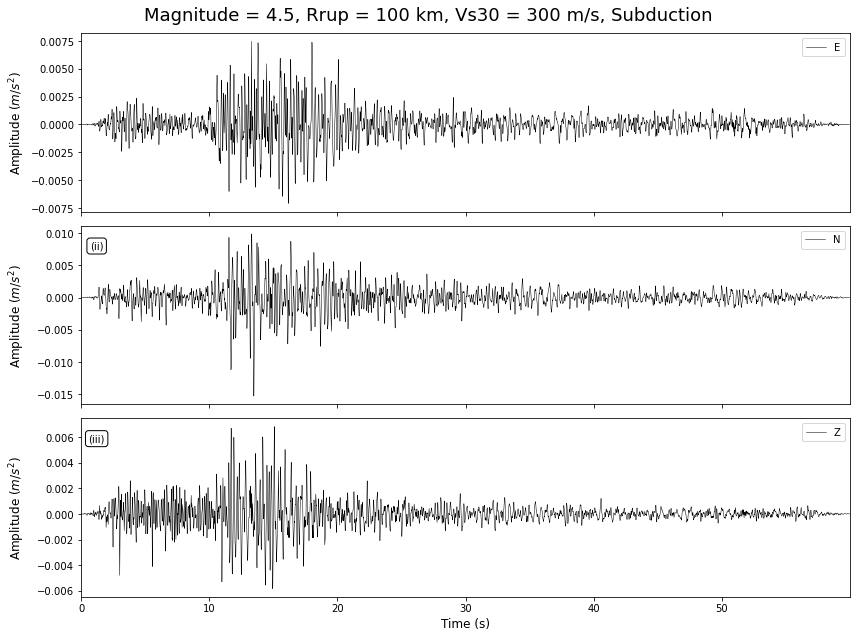

In [7]:
plot_one_example(fake_wfs_scen_corrected[0], v_names)